In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import torch

import numpy as np
import matplotlib.pylab as plt

from os.path import join
from pathlib import Path

from models.VQVAE import VectorQuantizerEMA, Encoder, Decoder

import pytorch_lightning as pl

from torchvision.utils import make_grid
from customLoader import CustomMinecraftData
from torchvision.transforms import transforms


In [3]:
class VQVAE(pl.LightningModule):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0,
                 batch_size=256, lr=0.001, split=0.95, img_size=64):
        super(VQVAE, self).__init__()


        self.batch_size = batch_size
        self.lr = lr
        self.split = split

        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        # self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
        #                               out_channels=embedding_dim,
        #                               kernel_size=1,
        #                               stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(num_hiddens,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

        self.example_input_array = torch.rand(batch_size, 3, img_size, img_size)

        self.transform = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                ])

    def forward(self, x):
        z = self._encoder(x)
        # z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

    def training_step(self, batch, batch_idx):

        vq_loss, data_recon, perplexity = self(batch)
        recon_error = F.mse_loss(data_recon, batch)
        loss = recon_error + vq_loss

        self.log('loss/train', loss, on_step=False, on_epoch=True)
        self.log('perplexity/train', perplexity, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):

        vq_loss, data_recon, perplexity = self(batch)
        recon_error = F.mse_loss(data_recon, batch)
        loss = recon_error + vq_loss

        self.log('loss/val', loss, on_step=False, on_epoch=True)
        self.log('perplexity/val', perplexity, on_step=False, on_epoch=True)

        if batch_idx == 0:
            grid = make_grid(data_recon[:64].cpu().data)
            grid = grid.permute(1,2,0)
            self.logger.experiment.log({"Images": [wandb.Image(grid.numpy())]})

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(params=self.parameters(), lr=self.lr, weight_decay=1e-5)

    def train_dataloader(self):
        train_dataset = CustomMinecraftData('CustomTrajectories1', 'train', self.split, transform=self.transform)
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)
        return train_dataloader

    def val_dataloader(self):
        val_dataset = CustomMinecraftData('CustomTrajectories1', 'val', self.split, transform=self.transform)
        val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)
        return val_dataloader


    def get_centroids(self, idx):
        z_idx = torch.tensor(idx).cuda()
        embeddings = torch.index_select(self._vq_vae._embedding.weight.detach(), dim=0, index=z_idx)
        embeddings = embeddings.view((1,2,2,64))
        embeddings = embeddings.permute(0, 3, 1, 2).contiguous()

        return self._decoder(embeddings)

    def save_encoding_indices(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        _, _, _, encoding_indices = self._vq_vae(z)
        return encoding_indices

In [4]:
conf = {
  'split': 0.95,
  'lr': 0.001,
  'batch_size': 256,
  'num_hiddens': 64,
  'num_residual_hiddens': 32,
  'num_residual_layers': 2,
  'embedding_dim': 256,
  'num_embeddings': 10,
  'commitment_cost': 0.25,
  'decay': 0.99
}

In [5]:
vqvae = VQVAE(**conf).cuda()
vqvae.eval()

VQVAE(
  (_encoder): Encoder(
    (_conv_1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_4): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_5): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (1): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

In [6]:
vqvae._vq_vae._embedding.weight

Parameter containing:
tensor([[-0.5455,  1.1591,  1.1954,  ..., -2.0917,  0.4341,  0.1872],
        [ 0.4636, -1.2984,  0.2541,  ...,  0.6215, -1.2540, -0.3991],
        [-0.5696, -0.5484,  0.8563,  ..., -0.1659,  0.9205, -0.5883],
        ...,
        [-0.2716,  1.0067, -0.1890,  ..., -0.5203, -0.3009,  0.1940],
        [ 1.3373,  0.8617,  0.2214,  ..., -1.3283, -0.1418, -0.3742],
        [-1.1989, -1.2890, -0.6230,  ...,  1.5987,  0.4850,  0.2366]],
       device='cuda:0', requires_grad=True)

In [25]:
path = '../results/vqvae_0.2/mineRL/y77fc26u/checkpoints/epoch=808-step=61483.ckpt'

path = '../results/vqvae_0.1/mineRL/2wgoga4p/checkpoints/epoch=833-step=62549.ckpt'
checkpoint = torch.load(path)


In [26]:
vqvae.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [27]:
vqvae._vq_vae._embedding.weight

Parameter containing:
tensor([[0.1865, 0.4844, 0.0976,  ..., 0.0471, 0.0787, 0.0669],
        [0.2315, 0.5058, 0.1621,  ..., 2.3773, 0.0679, 0.1075],
        [0.2080, 0.4973, 0.1455,  ..., 1.1755, 0.0691, 0.0929],
        ...,
        [0.2179, 0.3968, 0.1490,  ..., 2.0377, 0.0677, 0.0989],
        [0.2257, 0.3516, 0.1429,  ..., 0.6584, 0.0790, 0.0935],
        [0.2154, 1.0265, 0.1780,  ..., 2.3069, 0.0673, 0.1108]],
       device='cuda:0', requires_grad=True)

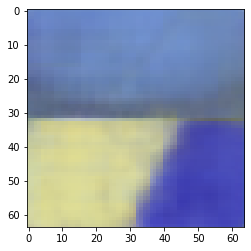

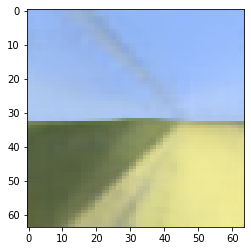

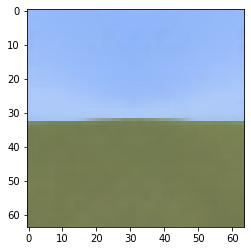

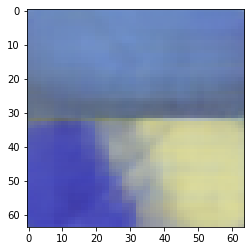

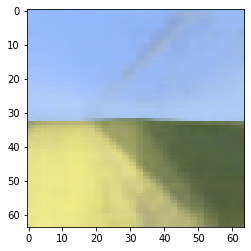

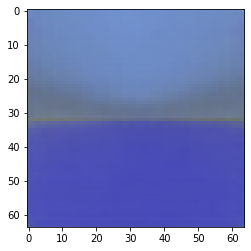

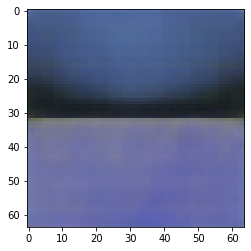

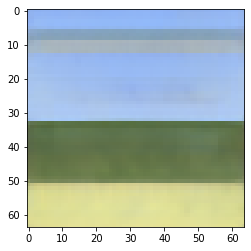

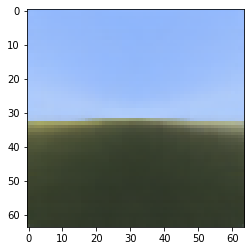

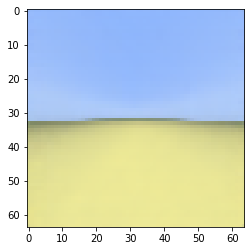

In [28]:
for i in range(10):
    out = vqvae.get_centroids(i)
    img = out.squeeze().permute(1,2,0).detach().cpu().numpy()
    img = img + 0.5
    img[img>1] = 1
    plt.imshow(img)
    plt.show()
    #plt.imsave(f"../goal_states_flat_biome/centroid_{i}.png", img)